# Table of Contents
* [Inference Framework for Segregation Measures: Segregation Index Construction](#Inference-Framework-for-Segregation-Measures:-Segregation-Index-Construction)
	* [Reading the entire dataset of Census](#Reading-the-entire-dataset-of-Census)
	* [Reading the apropriate map file and Merging with the data](#Reading-the-apropriate-map-file-and-Merging-with-the-data)
* [First measure of segregation: Uneveness](#First-measure-of-segregation:-Uneveness)
	* [Dissimilarity Index (D)](#Dissimilarity-Index-%28D%29)
		* [Spatial D (SD)](#Spatial-D-%28SD%29)
	* [Gini coefficient](#Gini-coefficient)
	* [Entropy](#Entropy)
	* [Atkinson Index](#Atkinson-Index)
	* [Concentration Profile (R)](#Concentration-Profile-%28R%29)
* [Second measure of segregation: Isolation](#Second-measure-of-segregation:-Isolation)
	* [Isolation (xPx)](#Isolation-%28xPx%29)
	* [Exposure (xPy)](#Exposure-%28xPy%29)
	* [Correlation Ratio (V) / $Eta^2$ / Symetric Isolation](#Correlation-Ratio-%28V%29-/-$Eta^2$-/-Symetric-Isolation)
* [Third measure of segregation: Clustering](#Third-measure-of-segregation:-Clustering)
	* [Spatial Proximity](#Spatial-Proximity)
	* [Relative Clustering Measure](#Relative-Clustering-Measure)
* [Isolation Revisited: Spatial Isolation ($SxPx$) and Spatial Exposure ($SxPy$)](#Isolation-Revisited:-Spatial-Isolation-%28$SxPx$%29-and-Spatial-Exposure-%28$SxPy$%29)
* [Fourth measure of segregation: Concentration](#Fourth-measure-of-segregation:-Concentration)
	* [Delta](#Delta)
	* [Relative Concentration Index (RCO)](#Relative-Concentration-Index-%28RCO%29)
* [Fifth measure of segregation: Centralization](#Fifth-measure-of-segregation:-Centralization)
	* [Absolute Centralization](#Absolute-Centralization)
	* [Relative Centralization](#Relative-Centralization)
* [Function that calculates the segregation measure for a specific group](#Function-that-calculates-the-segregation-measure-for-a-specific-group)
* [Checking how each measure behaves in an uniform distribution (society under eveness)](#Checking-how-each-measure-behaves-in-an-uniform-distribution-%28society-under-eveness%29)


# Inference Framework for Segregation Measures: Segregation Index Construction

All the data and supplementary files can be found at: https://github.com/renanxcortes/inequality-segregation-supplementary-files

In [37]:
# !IPython.load_extensions('calico-document-tools') To construct notebook Table of Contents
import pandas as pd
import pysal as ps
import geopandas as gpd
from libpysal.weights import Queen, Rook, KNN
import libpysal
import scipy
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from scipy.ndimage.interpolation import shift

import os

In [9]:
'''
This example uses all census data that the user must provide your own copy of the external database.
A step-by-step procedure for downloading the data can be found here: https://github.com/spatialucr/osnap/tree/master/osnap/data.
After the user download the LTDB_Std_All_fullcount.zip and extract the files, the filepath might be something like presented below.
filepath = '~/data/std_2010_fullcount.csv'
'''
os.chdir('C:/Users/renan/Desktop/full_count_2010')

## Reading the entire dataset of Census

In [11]:
census_2010 = pd.read_csv('std_2010_fullcount.csv', encoding = "ISO-8859-1", sep = ",")
census_2010.head()

,trtid10,state,county,tract,pop10,nhwht10,nhblk10,ntv10,asian10,hisp10,...,a15hsp10,a60hsp10,ageasn10,a15asn10,a60asn10,agentv10,a15ntv10,a60ntv10,globd10,globg10
0,1001020100,AL,Autauga County,Census Tract 201,1912,1601,228,21,16,44,...,14,2,14,4,1,13,1,3,bw,White Black
1,6083002402,CA,Santa Barbara County,Census Tract 24.02,11406,1980,207,54,703,8439,...,2972,414,624,119,75,26,4,3,wha,Dual immig
2,1001020200,AL,Autauga County,Census Tract 202,2170,844,1226,9,13,75,...,14,1,5,0,0,5,3,1,bw,White Black
3,6083002102,CA,Santa Barbara County,Census Tract 21.02,2084,853,24,24,88,1088,...,342,84,61,4,16,11,0,4,wha,Dual immig
4,1001020300,AL,Autauga County,Census Tract 203,3373,2538,668,30,42,87,...,34,9,22,2,7,9,1,3,bw,White Black


This is a Inference Framework for segregation for non-hispanic black people for the Riverside County. So, let's just filter the data that we need: 

In [12]:
df = census_2010.loc[census_2010.county == "Riverside County"][['trtid10','tract','pop10','nhblk10']]

In [13]:
df.head()

,trtid10,tract,pop10,nhblk10
5727,6065042012,Census Tract 420.12,6242,677
5729,6065041911,Census Tract 419.11,10258,844
5731,6065041910,Census Tract 419.10,6342,405
5733,6065040816,Census Tract 408.16,2594,346
5735,6065040815,Census Tract 408.15,3586,429


## Reading the apropriate map file and Merging with the data

In [14]:
map_url = 'https://raw.githubusercontent.com/renanxcortes/inequality-segregation-supplementary-files/master/Tracts_grouped_by_County/06065.json'
map_gpd = gpd.read_file(map_url)
map_gpd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 13 columns):
STATEFP10     453 non-null object
COUNTYFP10    453 non-null object
TRACTCE10     453 non-null object
GEOID10       453 non-null object
NAME10        453 non-null object
COUNTY_ID     453 non-null object
county_id2    453 non-null int64
COUNTYNS10    453 non-null int64
NAME10_COU    453 non-null object
GEOID_MSA     453 non-null int64
NAME_MSA      453 non-null object
STATES_MSA    453 non-null object
geometry      453 non-null object
dtypes: int64(3), object(10)
memory usage: 46.1+ KB


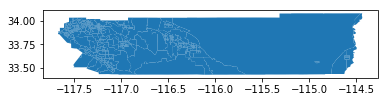

In [15]:
%matplotlib inline
map_gpd.plot()

It is necessary to harmonize the data type of the dataset and the geopandas in order to work the merging procedure.

In [16]:
map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
df_map = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')

Extracting only the columns that the inference framework will use.

In [17]:
df_mp = df_map[['GEOID10', 'tract', 'geometry', 'pop10', 'nhblk10']]
df_mp.head()

,GEOID10,tract,geometry,pop10,nhblk10
0,06065042012,Census Tract 420.12,"POLYGON ((-117.319414 33.902109, -117.322528 3...",6242,677
1,06065041911,Census Tract 419.11,"POLYGON ((-117.504056 33.800257, -117.502758 3...",10258,844
2,06065041910,Census Tract 419.10,"POLYGON ((-117.472451 33.762031, -117.475661 3...",6342,405
3,06065040816,Census Tract 408.16,"POLYGON ((-117.5285 33.89736, -117.529425 33.8...",2594,346
4,06065040815,Census Tract 408.15,"POLYGON ((-117.501299 33.89424899999999, -117....",3586,429


# First measure of segregation: Uneveness

According to (The Dimensions of Residential Segregation paper), the eveness refers to the differential distribution of two social groups among areal units in space. The chosen minority group, non-hispanic Black people in this case, is said to be segregated if it is unevenly distributed over  areal units. 

The percentage (%) of black people in Riverside County is:

In [18]:
df_mp.nhblk10.sum()/df_mp.pop10.sum() * 100

6.780106875967339

However, inside each census tract, there are some level of variation of this percentage:

In [19]:
(df_mp.nhblk10/df_mp.pop10 * 100).head(10)

0    10.845883
1     8.227725
2     6.385998
3    13.338473
4    11.963190
5    14.784609
6     3.486842
7     1.350575
8    12.102497
9     6.090026
dtype: float64

## Dissimilarity Index (D)

Introduced by *Duncan, O. and B. Duncan (1955). A methodological analysis of segregation indexes. American Sociological Review 20, 210–17.*, the Dissimilarity Index (D) is given by:

$$D=\sum_{i=1}^{n}\frac{t_i\mid p_i-P\mid}{2TP\left ( 1-P \right )}$$

$$0 \leqslant D \leqslant 1$$

Where $t_i$ is the total population of unit $i$, $p_i$ is the minority population of area $i$, $P$ is the global minority proportion and $T$ is the total population. Calculating these values below:

In [20]:
T = df_mp.loc[:,'pop10'].sum()
P = df_mp.loc[:,'nhblk10'].sum() / T
df_mp = df_mp.assign(ti = df_mp.loc[:,'pop10'],
                     pi = df_mp.loc[:,'nhblk10'] /df_mp.loc[:,'pop10'])
df_mp.head()

,GEOID10,tract,geometry,pop10,nhblk10,ti,pi
0,06065042012,Census Tract 420.12,"POLYGON ((-117.319414 33.902109, -117.322528 3...",6242,677,6242,0.108459
1,06065041911,Census Tract 419.11,"POLYGON ((-117.504056 33.800257, -117.502758 3...",10258,844,10258,0.082277
2,06065041910,Census Tract 419.10,"POLYGON ((-117.472451 33.762031, -117.475661 3...",6342,405,6342,0.063860
3,06065040816,Census Tract 408.16,"POLYGON ((-117.5285 33.89736, -117.529425 33.8...",2594,346,2594,0.133385
4,06065040815,Census Tract 408.15,"POLYGON ((-117.501299 33.89424899999999, -117....",3586,429,3586,0.119632


In [21]:
D = (((df_mp.pop10 * abs(df_mp.pi - P)))/ (2 * T * P * (1 - P))).sum()
D

0.31565682496226544

 The interpretation of this value is that 31.57% of the black population would have to move to reach eveness in the Riverside County.

### Spatial D (SD)

Tha spatial D is as following:

$$SD = D-\frac{\sum_{i=1}^{n}\sum_{j=1}^{n}\left | z_i-z_j \right |c_{ij}}{\sum_{i=1}^{n}\sum_{j=1}^{n}c_{ij}}$$

where $z_i$ and $z_j$ are the proportions of the minority population in the units $i$ and $j$, respectively, and $c_{ij}$ denotes an element at $(i,j)$ in a matrix C, which becomes one only if $i$ and $j$ are considered neighbors.

In [22]:
que = Queen.from_dataframe(df_mp)
knn = KNN.from_dataframe(df_mp, k=4)
roo = Rook.from_dataframe(df_mp)

In [23]:
cij = que.full()[0]
# manhattan_distances used to compute absolute distances
num = np.multiply(manhattan_distances(df_mp[['pi']]), cij).sum()
den = cij.sum()
SD = D - num / den
SD

0.2864885055405311

### Boundary Spatial D (BSD)

Tha boundary spatial D is as following:

$$BSD = D - \frac{1}{2}{\sum_{i=1}^{n}\sum_{j=1}^{n}w_{ij} \left | z_i-z_j \right |}$$

where

$$w_{ij} = \frac{d_{ij}}{\sum_{j=1}^{n}d_{ij}}$$

where $z_i$ and $z_j$ are the proportions of the minority population in the units $i$ and $j$, respectively, and $d_{ij}$ is the length of the common boundary of areal units $i$ and $j$.

In [35]:
# Auxiliar Function
def _return_length_weighted_w(data):
    """
    Returns a PySAL weights object that the weights represent the length of the commom boudary of two areal units that share border.

    Parameters
    ----------

    data          : a geopandas DataFrame with a 'geometry' column.

    Notes
    -----
    Currently it's not making any projection.

    """
    
    if ('geometry' not in data.columns):    
        raise ValueError('The input data has to have a column named \'geometry\'')
    
    data['index'] = data.index
    w = libpysal.weights.Queen.from_dataframe(data, ids = data.index.tolist())
    
    adjlist = w.to_adjlist().merge(data[['index', 'geometry']], left_on='focal', right_on='index', how='left')\
              .drop('index', axis=1)\
              .merge(data[['index', 'geometry']], left_on='neighbor', right_on='index', 
                     how='left', suffixes=("_focal", "_neighbor"))\
              .drop('index', axis=1)
    
    # Transforming from pandas to geopandas
    adjlist = gpd.GeoDataFrame(adjlist, geometry='geometry_focal')
    adjlist['geometry_neighbor'] = gpd.GeoSeries(adjlist.geometry_neighbor)
    
    # Getting the shared boundaries
    adjlist['shared_boundary'] = adjlist.geometry_focal.intersection(adjlist.set_geometry('geometry_neighbor'))
    
    # Putting it back to a matrix
    adjlist['weight'] = adjlist.set_geometry('shared_boundary').length
    length_weighted_w = libpysal.weights.W.from_adjlist(adjlist[['focal', 'neighbor', 'weight']])
    
    return length_weighted_w

In [59]:
dij = _return_length_weighted_w(df_mp).full()[0]
wij = dij / np.sum(dij, axis = 1)

BSD = D - (1 / 2) * np.multiply(manhattan_distances(df_mp[['pi']]), wij).sum()
BSD

-6.256630833845383

## Gini coefficient

The Gini Coefficient (G) is given by:

$$G=\sum_{i=1}^{n}\sum_{j=1}^{n}\frac{t_it_j\mid p_i-p_j\mid}{2T^2P\left ( 1-P \right )}$$

In [24]:
num = (np.matmul(np.array(df_mp.ti)[np.newaxis].T, np.array(df_mp.ti)[np.newaxis]) * abs(np.array(df_mp.pi)[np.newaxis].T - np.array(df_mp.pi)[np.newaxis])).sum()
den = (2 * T**2 * P * (1-P))
G = num / den
G

0.44620350030600087

## Entropy

The global entropy is given by:

$$E = P \ log\left ( \frac{1}{P} \right )+\left ( 1-P \right )log\left ( \frac{1}{1-P} \right )$$

while the unit's entropy is analogously:

$$E_i = p_i \ log\left ( \frac{1}{p_i} \right )+\left ( 1-p_i \right )log\left ( \frac{1}{1-p_i} \right ).$$

Therefore, the entropy index (E) is given by:

$$H = \sum_{i=1}^{n}\frac{t_i\left ( E-E_i \right )}{ET}$$

In [25]:
E = P * np.log(1 / P) + (1 - P) * np.log(1 / (1 - P))
Ei = df_mp.pi * np.log(1 / df_mp.pi) + (1 - df_mp.pi) * np.log(1 / (1 - df_mp.pi))
H = (df_mp.ti * (E - Ei) / (E * T)).sum()
H

0.08636489348167173

## Atkinson Index

The Atkinson index (A) is given by:

$$A = 1 - \frac{P}{1-P}\left | \sum_{i=1}^{n}\left [ \frac{\left ( 1-p_i \right )^{1-b}p_i^bt_i}{PT} \right ] \right |^{\frac{1}{1-b}}$$

where $b$ is a shape parameter that determines how to weight the increments to segregation contributed by different portions of the Lorenz curve.

In [26]:
b = 0.5
A = 1 - (P / (1-P)) * abs((((1 - df_mp.pi) ** (1-b) * df_mp.pi ** b * df_mp.ti) / (P * T)).sum()) ** (1 / (1 - b))
A

0.16722406110274002

## Concentration Profile (R)

The Concentration profile measure is discussed in *Hong, Seong-Yun, and Yukio Sadahiro. "Measuring geographic segregation: a graph-based approach." Journal of Geographical Systems 16.2 (2014): 211-231.* and tries to inspect the evenness aspect of segregation.

The threshold proportion *t* is given by:

$$\upsilon_t = \frac{\sum_{i=1}^{k}\omega_ig(t,i)}{\sum_{i=1}^{k}\omega_i}$$

where $k$ denotes the number of census tracts, and $\omega_i$ the number of the minority population in the census tract $i$. In the equation, $g(t, i)$ is a logical function that is defined as:


\begin{equation}
  g(t,i) =
  \begin{cases}
    1 & \text{if $\frac{\omega_i}{\Omega_i} \geqslant t$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}

where $\Omega_i$ is the total number of the population in the census tract $i$.

In [27]:
m = 1000 # Number of thresholds to be used
def calculate_vt(t):
    g_t_i = np.where(df_mp.nhblk10 / df_mp.pop10 >= t, 1, 0)
    v_t = (g_t_i * df_mp.nhblk10).sum() / df_mp.nhblk10.sum()
    return v_t

grid = np.linspace(0, 1, m)
curve = np.array(list(map(calculate_vt, grid)))

The Concentration Profile ($R$) is given by:

$$R=\frac{p-\left ( \int_{t=0}^{p}\upsilon_tdt - \int_{t=p}^{1}\upsilon_tdt \right )}{1-p}$$

where $p$ is the global proportion of the minority group.

In [28]:
threshold = df_mp.nhblk10.sum() / df_mp.pop10.sum()
R = ((threshold - ((curve[grid < threshold]).sum() / m - (curve[grid >= threshold]).sum()/ m)) / (1 - threshold))
R

0.06393365660089256

# Second measure of segregation: Isolation

## Isolation (xPx)

Isolation assess how much a minority group is only exposed to the same group. In other words, how much they only interact the members of the group that they belong. Assuming X as the minority group, the equation is giving by:

$$xPx=\sum_{i=1}^{n}\left ( \frac{x_i}{X} \right )\left ( \frac{x_i}{t_i} \right )$$

$$0 \leqslant xPx \leqslant 1$$

where $x_i$ is the number of members of group $x$ in area $i$, $X$ is the total population of the minority group.

In [29]:
df_mp = df_mp.assign(xi = df_mp.loc[:,'nhblk10'],
                     yi = df_mp.loc[:,'pop10'] - df_mp.loc[:,'nhblk10'])
X = df_mp.xi.sum()
Y = df_mp.yi.sum()

In [30]:
xPx = ((df_mp.xi / X) * (df_mp.xi / df_mp.ti)).sum()
xPx

0.11321482777341298

The interpretation of this number is that if you randomly pick a X member of a specific area, there is 11.32% of probability that this member shares a unit with another X member. 

## Exposure (xPy)

An analogous measure of **exposure** of group $X$ to the group $Y$ could be analogous reached through:

$$xPy=\sum_{i=1}^{n}\left ( \frac{x_i}{X} \right )\left ( \frac{y_i}{t_i} \right )$$

$$0 \leqslant xPy \leqslant 1$$

In [31]:
xPy = ((df_mp.xi / X) * (df_mp.yi / df_mp.ti)).sum()
xPy

0.886785172226587

## Correlation Ratio (V) / $Eta^2$ / Symetric Isolation

The correlation ratio (V or $Eta^2$) is given by

$$V = Eta^2 = \frac{xPx - P}{1 - P}$$

In [32]:
V = (xPx - P) / (1 - P)
V

0.048716810856363923

# Third measure of segregation: Clustering

## Spatial Proximity

The clustering measure assess the extent to which areal units inhabited by minority members adjoin one another, or cluster, in space. This Spatial Proximity Index (SP) is evaluated between two distinct groups X (non-hispanic black, for example) and Y (other than non-hipanic black, for example). The equation is:

$$SP = \frac{XP_{xx} + YP_{yy}}{TP_{tt}}$$

$$SP \geqslant 1$$

where

$$P_{xx} = \sum_{i=1}^{n}\sum_{j=1}^{n}\frac{x_ix_jc_{ij}}{X^2}$$
$$P_{yy} = \sum_{i=1}^{n}\sum_{j=1}^{n}\frac{y_iy_jc_{ij}}{Y^2}$$
$$P_{tt} = \sum_{i=1}^{n}\sum_{j=1}^{n}\frac{t_it_jc_{ij}}{T^2}$$

$$c_{ij} = exp(-d_{ij})$$


$d_{ij}$ is a pairwise distance measure between area $i$ and $j$ and $d_{ii}$ is estimated as $d_{ii} = (\alpha a_i)^{\beta}$ where $a_i$ is the unit area. For the distance measure, we first extracts the centroids of each unit. The default is $\alpha = 0.6$ and $\beta = 0.5$.

In [29]:
df_mp = df_mp.assign(c_lons = df_mp.centroid.map(lambda p: p.x),
                     c_lats = df_mp.centroid.map(lambda p: p.y))

In [30]:
df_mp.head()

,GEOID10,tract,geometry,pop10,nhblk10,ti,pi,xi,yi,c_lons,c_lats
0,06065042012,Census Tract 420.12,"POLYGON ((-117.319414 33.902109, -117.322528 3...",6242,677,6242,0.108459,677,5565,-117.320504,33.910879
1,06065041911,Census Tract 419.11,"POLYGON ((-117.504056 33.800257, -117.502758 3...",10258,844,10258,0.082277,844,9414,-117.495803,33.742890
2,06065041910,Census Tract 419.10,"POLYGON ((-117.472451 33.762031, -117.475661 3...",6342,405,6342,0.063860,405,5937,-117.492951,33.786264
3,06065040816,Census Tract 408.16,"POLYGON ((-117.5285 33.89736, -117.529425 33.8...",2594,346,2594,0.133385,346,2248,-117.524611,33.902457
4,06065040815,Census Tract 408.15,"POLYGON ((-117.501299 33.89424899999999, -117....",3586,429,3586,0.119632,429,3157,-117.511500,33.893075


Now, we need to calculate the pairwise distance $d_{ij}$ in order to calculate $c_{ij} = exp(-d_{ij})$ which is a decreasing function of the distance. For the distance diagonal we take $d_{ii} = (0.6 a_i) ^ {0.5}$. We use the euclidean distance to compute the pair wise distance (not in the diagonal of the distance matrix).

In [31]:
dist = euclidean_distances(df_mp[['c_lons','c_lats']])
np.fill_diagonal(dist, val = (0.6*df_mp.area)**(1/2))
c = np.exp(-dist)
c

array([[0.987542  , 0.78443107, 0.80834959, ..., 0.63855674, 0.69032011,
        0.69299803],
       [0.78443107, 0.9379624 , 0.9574637 , ..., 0.55125288, 0.60088803,
        0.60881703],
       [0.80834959, 0.9574637 , 0.97471765, ..., 0.5523936 , 0.60186742,
        0.60888152],
       ...,
       [0.63855674, 0.55125288, 0.5523936 , ..., 0.99126376, 0.91737242,
        0.90354521],
       [0.69032011, 0.60088803, 0.60186742, ..., 0.91737242, 0.99001633,
        0.97872376],
       [0.69299803, 0.60881703, 0.60888152, ..., 0.90354521, 0.97872376,
        0.98945207]])

In [32]:
Pxx = ((np.array(df_mp.xi) * c).T * np.array(df_mp.xi)).sum() / X**2
Pyy = ((np.array(df_mp.yi) * c).T * np.array(df_mp.yi)).sum() / Y**2
Ptt = ((np.array(df_mp.ti) * c).T * np.array(df_mp.ti)).sum() / T**2
SP = (X*Pxx + Y*Pyy)/(T*Ptt)
SP

1.002191883006537

As mentioned in Hong et. al. (2014), SP is calculated based on an assumption that all people in each census tract is located at a representative point, such as the centroid of the tract, and thus, its reliability is limited by the validity of this assumption.

## Relative Clustering Measure

Another Clustering measure is the Relative Clustering Measure (RCL):

$$RCL = \frac{P_{xx}}{P_{yy}} - 1$$

In [33]:
RCL = Pxx / Pyy - 1
RCL

0.12418089857347714

# Isolation Revisited: Spatial Isolation ($SxPx$) and Spatial Exposure ($SxPy$)

Since the spatial version of the Isolation and Exposure takes into consideration the distance between units. They are presented here in order to take advantage of this already calculated values. It draw inspiration from Morgan (1983) *"A Distance-Decay Based Interaction Index to Measure Residential Segregation"*.

The Spatial Isolation (SxPx) is given by:

$$SxPx=\sum_{i=1}^{n}\left ( \frac{x_i}{X} \right )\left (\sum_{j=1}^{n}P_{ij} \left (\frac{x_i}{t_i}\right ) \right )$$

where $$P_{ij} = \frac{C_{ij}t_j}{\sum_{j=1}^{n}C_{ij}t_j}$$

such that

$$\sum_{j=1}^{n}P_{ij} = 1$$ and $C_{ij}$ is an estimated contact rate between unit $i$ and $j$. This also could be seen as the *probability of contact*. Currently, the estimation of $C_{ij}$ is the same as $c_{ij}$ before.

In [72]:
Pij = np.multiply(c, np.array(df_mp['ti'])) / np.sum(np.multiply(c, np.array(df_mp['ti'])), axis = 1)

SxPx = (np.array(df_mp['xi'] / X) * np.sum(np.multiply(Pij, np.array(df_mp['xi'] / df_mp['ti'])), axis = 1)).sum()
SxPx

0.07214112078134231

On the other hand, the spatial exposure ($SxPy$) is given by:

$$SxPy=\sum_{i=1}^{n}\left ( \frac{x_i}{X} \right )\left (\sum_{j=1}^{n}P_{ij} \left (\frac{y_i}{t_i}\right ) \right )$$

where $P_{ij}$ and $C_{ij}$ defined as before.

In [73]:
SxPy = (np.array(df_mp['xi'] / X) * np.sum(np.multiply(Pij, np.array(df_mp['yi'] / df_mp['ti'])), axis = 1)).sum()
SxPy

0.9605053172501217

# Fourth measure of segregation: Concentration

Concentration measurements estimate the amount of physical space that the minority people occupies in relation to the other group.

## Delta

The Delta measure is given by the following equation:

$$DEL = \frac{1}{2}\sum_{i=1}^{n}\left | \frac{x_i}{X} - \frac{a_i}{A} \right |$$

In [36]:
A = df_mp.area.sum()
DEL = 1/2 * abs(df_mp.xi / X - df_mp.area / A).sum()
DEL

0.8367330649317353

## Absolute Concentration Index (ACO)

The Absolute Concentration Index (ACO) is given by:

\begin{equation}
\large
ACO = 1-\frac{ \sum_{i=1}^{n}\left ( \frac{x_ia_i}{X} \right ) - \sum_{i=1}^{n_1}\left ( \frac{t_ia_i}{T_1} \right )}{ \sum_{i=n_2}^{n}\left ( \frac{t_ia_i}{T_2} \right ) - \sum_{i=1}^{n_1}\left ( \frac{t_ia_i}{T_1} \right )}
\end{equation}

where the units are **ordered** from **smallest to largest** in areal size. In this formula, $n_1$ is the rank of the unit where the cumulative total population equal the total minority population, $n_2$ is the rank of the unit where cumulative total population equal equal the total minority population **from the largest unit down**. In addition,

$$T_1 = \sum_{i=1}^{n_1}t_i$$

and

$$T_2 = \sum_{i=n_2}^{n}t_i$$

Below is presented the calculated index.

In [34]:
df_mp_sort_area = df_mp
df_mp_sort_area = df_mp_sort_area.assign(area = df_mp_sort_area.area)
df_mp_sort_area_asc = df_mp_sort_area.sort_values('area')

n1 = np.where(((np.cumsum(df_mp_sort_area_asc.ti) / T) < X/T) == False)[0][0]

df_mp_sort_area_des = df_mp_sort_area.sort_values('area', ascending=False)

n2 = np.where(((np.cumsum(df_mp_sort_area_des.ti) / T) < X/T) == False)[0][0]

n = df_mp_sort_area_asc.shape[0]
T1 =  df_mp_sort_area_asc.ti[0:(n1+1)].sum()
T2 =  df_mp_sort_area_asc.ti[n2:n].sum()

ACO = 1- ((((df_mp_sort_area_asc.xi*df_mp_sort_area_asc.area/X).sum()) - ((df_mp_sort_area_asc.ti*df_mp_sort_area_asc.area/T1)[0:(n1+1)].sum())) / \
          (((df_mp_sort_area_asc.ti*df_mp_sort_area_asc.area/T2)[n2:n].sum()) - ((df_mp_sort_area_asc.ti*df_mp_sort_area_asc.area/T1)[0:(n1+1)].sum())))
ACO

0.5430616390401855

The step-by-step explanation of the intermediate steps is present in the next index, since they're analogous to the ACO.

## Relative Concentration Index (RCO)

Another measure of concentration is the Relative Concentration Index (RCO).

\begin{equation}
\large
RCO = \frac{\frac{\sum_{i=1}^{n}\left ( \frac{x_ia_i}{X} \right )}{\sum_{i=1}^{n}\left ( \frac{y_ia_i}{Y} \right )}-1}{\frac{\sum_{i=1}^{n_1}\left ( \frac{t_ia_i}{T_1} \right )}{\sum_{i=n_2}^{n}\left ( \frac{t_ia_i}{T_2} \right )}-1}
\end{equation}

where $n_1$, $n_2$, $T_1$ and $T_2$ are defined as before.

In order to calculate it, we need to sort the data set from smallest to largest units (ascending order).

In [37]:
df_mp_sort_area = df_mp
df_mp_sort_area = df_mp_sort_area.assign(area = df_mp_sort_area.area)
df_mp_sort_area_asc = df_mp_sort_area.sort_values('area')
df_mp_sort_area_asc.head()

,GEOID10,tract,geometry,pop10,nhblk10,ti,pi,xi,yi,c_lons,c_lats,area
215,06065041001,Census Tract 410.01,"POLYGON ((-117.466911 33.955298, -117.465999 3...",2832,107,2832,0.037782,107,2725,-117.464408,33.949685,0.000048
308,06065030101,Census Tract 301.01,"POLYGON ((-117.352089 34.001387, -117.351409 3...",1226,72,1226,0.058728,72,1154,-117.352033,33.997116,0.000049
147,06065030503,Census Tract 305.03,"POLYGON ((-117.348497 33.976808, -117.357157 3...",3812,254,3812,0.066632,254,3558,-117.352826,33.979899,0.000054
93,06065045704,Census Tract 457.04,"POLYGON ((-116.181625 33.674717, -116.179482 3...",2804,4,2804,0.001427,4,2800,-116.182382,33.671241,0.000069
187,06065041905,Census Tract 419.05,"POLYGON ((-117.597468 33.878735, -117.596682 3...",2935,165,2935,0.056218,165,2770,-117.604257,33.869711,0.000078


In the formula, $n_1$ is the rank of the area unit where the cumulative total population equal the total minority population of the city. In theory, the value will not necessarily be equal, so we get the first index that this cumulative proportion exceed the overall minority proportion.

In [38]:
n1 = np.where(((np.cumsum(df_mp_sort_area_asc.ti) / T) < X/T) == False)[0][0]
n1

44

Also, we need to calculate $n_2$ which is the rank of the unit where total population equal the total minority proportion from the largest unit down.

In [39]:
df_mp_sort_area_des = df_mp_sort_area.sort_values('area', ascending=False)
df_mp_sort_area_des.head()

,GEOID10,tract,geometry,pop10,nhblk10,ti,pi,xi,yi,c_lons,c_lats,area
370,06065046900,Census Tract 469,"POLYGON ((-116.301807 33.875564, -116.301178 3...",2043,52,2043,0.025453,52,1991,-115.363506,33.778283,0.959739
56,06065044403,Census Tract 444.03,"POLYGON ((-116.268103 33.612652, -116.267984 3...",4402,40,4402,0.009087,40,4362,-116.465255,33.503507,0.103305
158,06065044402,Census Tract 444.02,"POLYGON ((-116.725042 33.70449, -116.724298 33...",6218,122,6218,0.019620,122,6096,-116.727016,33.605403,0.063803
161,06065045604,Census Tract 456.04,"POLYGON ((-116.026424 33.426331, -116.026548 3...",13694,28,13694,0.002045,28,13666,-115.936149,33.498241,0.041041
230,06065044405,Census Tract 444.05,"POLYGON ((-116.835243 33.857036, -116.824431 3...",2366,44,2366,0.018597,44,2322,-116.694487,33.794717,0.031706


The same approximation, as before, we do to extract this index.

In [40]:
n2 = np.where(((np.cumsum(df_mp_sort_area_des.ti) / T) < X/T) == False)[0][0]
n2

32

Calculating the Relative Concentration Index:

In [41]:
n = df_mp_sort_area_asc.shape[0]
T1 =  df_mp_sort_area_asc.ti[0:(n1+1)].sum()
T2 =  df_mp_sort_area_asc.ti[n2:n].sum()

RCO = ((((df_mp_sort_area_asc.xi*df_mp_sort_area_asc.area/X).sum()) / ((df_mp_sort_area_asc.yi*df_mp_sort_area_asc.area/Y).sum())) - 1) / \
      ((((df_mp_sort_area_asc.ti*df_mp_sort_area_asc.area)[0:(n1+1)].sum() / T1) / ((df_mp_sort_area_asc.ti*df_mp_sort_area_asc.area)[n2:n].sum() / T2)) - 1)
RCO

0.5364305924831142

# Fifth measure of segregation: Centralization

This measure estimate how far from the central business district the minority people is. This segregation aspect can be evaluated thourgh the Absolute Centralization Index (ACE) or through the Relative Centralization Indec (RCE):

$$ACE=\left ( \sum_{i=2}^{n}X_{i-1}A_i \right ) - \left ( \sum_{i=2}^{n}X_{i}A_{i-1} \right )$$

$$RCE=\left ( \sum_{i=2}^{n}X_{i-1}Y_i \right ) - \left ( \sum_{i=2}^{n}X_{i}Y_{i-1} \right )$$

$$-1 \leqslant RCE \leqslant 1$$

where $A_i$ is the cumulative area proportion through unit $i$, $X_i$ is the cumulative frequency proportion through unit $i$ of group X and $Y_i$ is the analogous for group Y. In this measure, **the area units are ordered by increasing distances from the central business district**. 

First we need to calculate the distance of each tract from what is considered the central business center. However, this center is not well-defined in first hand. In this case, we make the hyhotesis that the center latitudes and longitudes is an approximation of this considered *center*.

In [32]:
df_mp = df_mp.assign(center_lon  = df_mp.c_lons.mean(),
                     center_lat = df_mp.c_lats.mean())
df_mp['center_dist'] = np.sqrt((df_mp.c_lons - df_mp.center_lon)**2 + (df_mp.c_lats - df_mp.center_lat)**2)
df_mp_sort_cent = df_mp.sort_values('center_dist')
df_mp_sort_cent.head()

,GEOID10,tract,geometry,pop10,nhblk10,ti,pi,xi,yi,c_lons,c_lats,center_lon,center_lat,center_dist
262,06065043517,Census Tract 435.17,"POLYGON ((-117.044067 33.869754, -117.042275 3...",6815,742,6815,0.108877,742,6073,-117.024606,33.823242,-117.015209,33.80972,0.016467
52,06065043506,Census Tract 435.06,"POLYGON ((-116.980479 33.758405, -116.98438 33...",6386,356,6386,0.055747,356,6030,-116.994328,33.769676,-117.015209,33.80972,0.045161
238,06065043602,Census Tract 436.02,"POLYGON ((-116.972012 33.799843, -116.968917 3...",3953,191,3953,0.048318,191,3762,-116.966300,33.787527,-117.015209,33.80972,0.053709
84,06065051300,Census Tract 513,"POLYGON ((-116.972012 33.799843, -116.971944 3...",8371,513,8371,0.061283,513,7858,-116.961694,33.815642,-117.015209,33.80972,0.053842
50,06065043505,Census Tract 435.05,"POLYGON ((-116.997874 33.758274, -116.997906 3...",2911,189,2911,0.064926,189,2722,-116.993529,33.758309,-117.015209,33.80972,0.055796


Calculating the cumulative proportion of the variables ordered by the distance of the center. These measures are used to calculate either Absolute Centralization Index (ACE) or Relative Centralization Index (RCE).

In [33]:
df_mp_sort_cent['Xi'] = np.cumsum(df_mp_sort_cent.xi) / X
df_mp_sort_cent['Yi'] = np.cumsum(df_mp_sort_cent.yi) / Y
df_mp_sort_cent['Ai'] = np.cumsum(df_mp_sort_cent.area) / A

These new variables reach the value of one at the end of the dataset.

In [34]:
df_mp_sort_cent.tail()

,GEOID10,tract,geometry,pop10,nhblk10,ti,pi,xi,yi,c_lons,c_lats,center_lon,center_lat,center_dist,Xi,Yi,Ai
420,06065046103,Census Tract 461.03,"POLYGON ((-114.605968 33.632046, -114.599818 3...",3030,104,3030,0.034323,104,2926,-114.597233,33.624902,-117.015209,33.80972,2.425029,0.994665,0.996314,0.987896
418,06065046200,Census Tract 462,"POLYGON ((-114.570768 33.6108, -114.570684 33....",3341,516,3341,0.154445,516,2825,-114.596687,33.599470,-117.015209,33.80972,2.427644,0.998141,0.997698,0.988516
421,06065046101,Census Tract 461.01,"POLYGON ((-114.596796 33.610354, -114.596858 3...",3060,192,3060,0.062745,192,2868,-114.583893,33.614224,-117.015209,33.80972,2.439163,0.999434,0.999103,0.988619
173,06065047000,Census Tract 470,"POLYGON ((-114.511972 33.735019, -114.512348 3...",1749,81,1749,0.046312,81,1668,-114.561894,33.620277,-117.015209,33.80972,2.460619,0.999980,0.999920,0.995967
172,06065940100,Census Tract 9401,"POLYGON ((-114.504839 33.760205, -114.516989 3...",166,3,166,0.018072,3,163,-114.491170,33.965624,-117.015209,33.80972,2.528849,1.000000,1.000000,1.000000


## Absolute Centralization

In [35]:
ACE = (shift(df_mp_sort_cent.Xi, 1, cval=np.NaN) * df_mp_sort_cent.Ai).sum() - \
      (df_mp_sort_cent.Xi * shift(df_mp_sort_cent.Ai, 1, cval=np.NaN)).sum()
ACE

0.6416113799795511

## Relative Centralization

In [36]:
RCE = (shift(df_mp_sort_cent.Xi, 1, cval=np.NaN) * df_mp_sort_cent.Yi).sum() - \
      (df_mp_sort_cent.Xi * shift(df_mp_sort_cent.Yi, 1, cval=np.NaN)).sum()
RCE

0.18550429720565376

# Function that calculates the segregation measure for a specific group

In [80]:
def calculate_segregation(data, group_pop_var, total_pop_var, b = 0.5, m = 1000):
    '''
    data: a geopandas DataFrame that contains a geometry column
    group_pop_var: the name of variable that contains the population size of the group of interest
    total_pop_var: the name of variable that contains the total population of the unit
    b: Atksinson's Index shape parameter
    m: a numeric value indicating the number of thresholds to be used in the Concentration Profile Index
    '''
    
    # Uneveness
    data = data.rename(columns={group_pop_var: 'group_pop_var', total_pop_var: 'total_pop_var'})
    T = data.total_pop_var.sum()
    P = data.group_pop_var.sum() / T
    data = data.assign(xi = data.group_pop_var,
                       yi = data.total_pop_var - data.group_pop_var,
                       ti = data.total_pop_var,
                       pi = np.where(data.total_pop_var == 0, 0, data.group_pop_var/data.total_pop_var))
    D = (((data.total_pop_var * abs(data.pi - P)))/ (2 * T * P * (1 - P))).sum()
    
    
    num = (np.matmul(np.array(data.ti)[np.newaxis].T, np.array(data.ti)[np.newaxis]) * abs(np.array(data.pi)[np.newaxis].T - np.array(data.pi)[np.newaxis])).sum()
    den = (2 * T**2 * P * (1-P))
    G = num / den
    
    E = P * np.log(1 / P) + (1 - P) * np.log(1 / (1 - P))
    Ei = data.pi * np.log(1 / data.pi) + (1 - data.pi) * np.log(1 / (1 - data.pi))
    H = (data.ti * (E - Ei) / (E * T)).sum()
    
    Atk = 1 - (P / (1-P)) * abs((((1 - data.pi) ** (1-b) * data.pi ** b * data.ti) / (P * T)).sum()) ** (1 / (1 - b))
    
    def calculate_vt(t):
        g_t_i = np.where(data.xi / data.ti >= t, 1, 0)
        v_t = (g_t_i * data.xi).sum() / data.xi.sum()
        return v_t

    grid = np.linspace(0, 1, m)
    curve = np.array(list(map(calculate_vt, grid)))
    
    threshold = data.xi.sum() / data.ti.sum()
    R = ((threshold - ((curve[grid < threshold]).sum() / m - (curve[grid >= threshold]).sum()/ m)) / (1 - threshold))
    
    
    # Isolation
    X = data.xi.sum()
    Y = data.yi.sum()
    xPx = ((data.xi / X) * (data.xi / data.ti)).sum()
    xPy = ((data.xi / X) * (data.yi / data.ti)).sum()
    
    V = (xPx - P) / (1 - P)
    
    # Clustering
    data = data.assign(c_lons = data.centroid.map(lambda p: p.x),
                       c_lats = data.centroid.map(lambda p: p.y))
    dist = euclidean_distances(data[['c_lons','c_lats']])
    np.fill_diagonal(dist, val = (0.6*data.area)**(1/2))
    c = np.exp(-dist)
    Pxx = ((np.array(data.xi) * c).T * np.array(data.xi)).sum() / X**2
    Pyy = ((np.array(data.yi) * c).T * np.array(data.yi)).sum() / Y**2
    Ptt = ((np.array(data.ti) * c).T * np.array(data.ti)).sum() / T**2
    
    SP = (X*Pxx + Y*Pyy)/(T*Ptt)
    RCL = Pxx / Pyy - 1

    # Concentration
    A = data.area.sum()
    DEL = 1/2 * abs(data.xi / X - data.area / A).sum()
    
    df_mp_sort_area = data
    df_mp_sort_area = df_mp_sort_area.assign(area = df_mp_sort_area.area)
    df_mp_sort_area_asc = df_mp_sort_area.sort_values('area')
    n1 = np.where(((np.cumsum(df_mp_sort_area_asc.ti) / T) < X/T) == False)[0][0]
    
    df_mp_sort_area_des = df_mp_sort_area.sort_values('area', ascending=False)
    n2 = np.where(((np.cumsum(df_mp_sort_area_des.ti) / T) < X/T) == False)[0][0]
    
    n = df_mp_sort_area_asc.shape[0]
    T1 =  df_mp_sort_area_asc.ti[0:(n1+1)].sum()
    T2 =  df_mp_sort_area_asc.ti[n2:n].sum()

    RCO = ((((df_mp_sort_area_asc.xi*df_mp_sort_area_asc.area/X).sum()) / ((df_mp_sort_area_asc.yi*df_mp_sort_area_asc.area/Y).sum())) - 1) / \
          ((((df_mp_sort_area_asc.ti*df_mp_sort_area_asc.area)[0:(n1+1)].sum() / T1) / ((df_mp_sort_area_asc.ti*df_mp_sort_area_asc.area)[n2:n].sum() / T2)) - 1)


    
    # Centralization
    data = data.assign(center_lon = data.c_lons.mean(),
                       center_lat = data.c_lats.mean())
    data['center_dist'] = np.sqrt((data.c_lons - data.center_lon)**2 + (data.c_lats - data.center_lat)**2)
    data_sort_cent = data.sort_values('center_dist')
    
    data_sort_cent = data_sort_cent.assign(Xi = np.cumsum(data_sort_cent.xi) / X,
                                           Yi = np.cumsum(data_sort_cent.yi) / Y,
                                           Ai = np.cumsum(data_sort_cent.area) / A)
    
    ACE = (shift(data_sort_cent.Xi, 1, cval=np.NaN) * data_sort_cent.Ai).sum() - \
          (data_sort_cent.Xi * shift(data_sort_cent.Ai, 1, cval=np.NaN)).sum()
    
    RCE = (shift(data_sort_cent.Xi, 1, cval=np.NaN) * data_sort_cent.Yi).sum() - \
          (data_sort_cent.Xi * shift(data_sort_cent.Yi, 1, cval=np.NaN)).sum()
    
    return {'Dissimilarity (D)': D, 
            'Gini (G)': G,
            'Entropy (H)': H,
            'Atkinson (A)': Atk,
            'Concentration Profile (R)': R,
            
            'Isolation (xPx)': xPx, 
            'Exposure (xPy)': xPy, 
            'Correlation Ratio (V)': V,
            
            'Spatial Proximity (clustering) (SP)': SP, 
            'Relative Clustering (RCL)': RCL, 
            
            'Delta (concentration) (DEL)': DEL,
            'Relative Concentration (RCO)': RCO,
            
            'Absolute Centralization (ACE)': ACE,
            'Relative Centralization (RCE)': RCE
           }

Testing the function returning values:

In [81]:
calculate_segregation(df_mp, 'nhblk10', 'pop10')

{'Dissimilarity (D)': 0.31565682496226544,
 'Gini (G)': 0.44620350030600087,
 'Entropy (H)': 0.08636489348167173,
 'Atkinson (A)': 0.16722406110274002,
 'Concentration Profile (R)': 0.06393365660089256,
 'Isolation (xPx)': 0.11321482777341298,
 'Exposure (xPy)': 0.886785172226587,
 'Correlation Ratio (V)': 0.048716810856363923,
 'Spatial Proximity (clustering) (SP)': 1.002191883006537,
 'Relative Clustering (RCL)': 0.12418089857347714,
 'Delta (concentration) (DEL)': 0.8367330649317353,
 'Relative Concentration (RCO)': 0.5364305924831142,
 'Absolute Centralization (ACE)': 0.6416113799795511,
 'Relative Centralization (RCE)': 0.18550429720565376}

Testing the function for the hispanic group.

In [82]:
df_hisp = census_2010.loc[census_2010.county == "Riverside County"][['trtid10','tract','pop10', 'hisp10']]
df_map_hisp = map_gpd.merge(df_hisp, left_on = 'INTGEOID10', right_on = 'trtid10')
calculate_segregation(df_map_hisp, 'hisp10', 'pop10')

{'Dissimilarity (D)': 0.36185875476973617,
 'Gini (G)': 0.4946105306516753,
 'Entropy (H)': 0.15115364087158104,
 'Atkinson (A)': 0.21124532995856793,
 'Concentration Profile (R)': 0.3575921031865351,
 'Isolation (xPx)': 0.5579490535561749,
 'Exposure (xPy)': 0.4420509464438251,
 'Correlation Ratio (V)': 0.18959658165028695,
 'Spatial Proximity (clustering) (SP)': 1.0034327772290552,
 'Relative Clustering (RCL)': -0.03548356454916657,
 'Delta (concentration) (DEL)': 0.8007126017818965,
 'Relative Concentration (RCO)': -0.04111382688802874,
 'Absolute Centralization (ACE)': 0.551306249058257,
 'Relative Centralization (RCE)': -0.09523364307804627}

# Checking how each measure behaves in an uniform distribution (society under eveness)

In [83]:
df_map_hisp['toy_group_pop'] = 10
df_map_hisp['toy_tot_pop']   = 100
calculate_segregation(df_map_hisp, 'toy_group_pop', 'toy_tot_pop')

{'Dissimilarity (D)': 0.0,
 'Gini (G)': 0.0,
 'Entropy (H)': 0.0,
 'Atkinson (A)': -6.661338147750939e-16,
 'Concentration Profile (R)': 0.0,
 'Isolation (xPx)': 0.1,
 'Exposure (xPy)': 0.9000000000000001,
 'Correlation Ratio (V)': 0.0,
 'Spatial Proximity (clustering) (SP)': 0.9999999999999999,
 'Relative Clustering (RCL)': 2.220446049250313e-16,
 'Delta (concentration) (DEL)': 0.7698929792458742,
 'Relative Concentration (RCO)': -0.0,
 'Absolute Centralization (ACE)': 0.5575902111158229,
 'Relative Centralization (RCE)': 0.0}